In [1]:
import os

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
%config InlineBackend.figure_format='retina'

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import sys
# Don't generate the __pycache__ folder locally
sys.dont_write_bytecode = True 
# Print exception without the buit-in python warning
sys.tracebacklimit = 0 

In [4]:
import tensorflow as tf

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical

In [6]:
from modules import *

In [7]:
# Define folder paths and target image size

folder_paths = ['./group_1', './group_2', './group_3']

In [8]:
# Set the batch size and number of epochs to use during training

batch_size = 16

epochs = 1000

learning_rate = 1e-5

img_size = (128, 128)

In [9]:
# Preprocess images and convert labels to integers

preprocessed_images, labels = preprocess_images(folder_paths, img_size)

Loading images:   0%|          | 0/600 [00:00<?, ?it/s]

Premature end of JPEG file


In [10]:
# Convert string labels to numerical labels

le = LabelEncoder()

labels = le.fit_transform(labels)

In [11]:
# Generate augmented images for all input images

n_augmentations = 25

augmented_images, augmented_labels = augment_images(img_size, 
                                                    preprocessed_images, labels, 
                                                    n_augmentations=n_augmentations)

Augmenting images:   0%|          | 0/15000 [00:00<?, ?it/s]

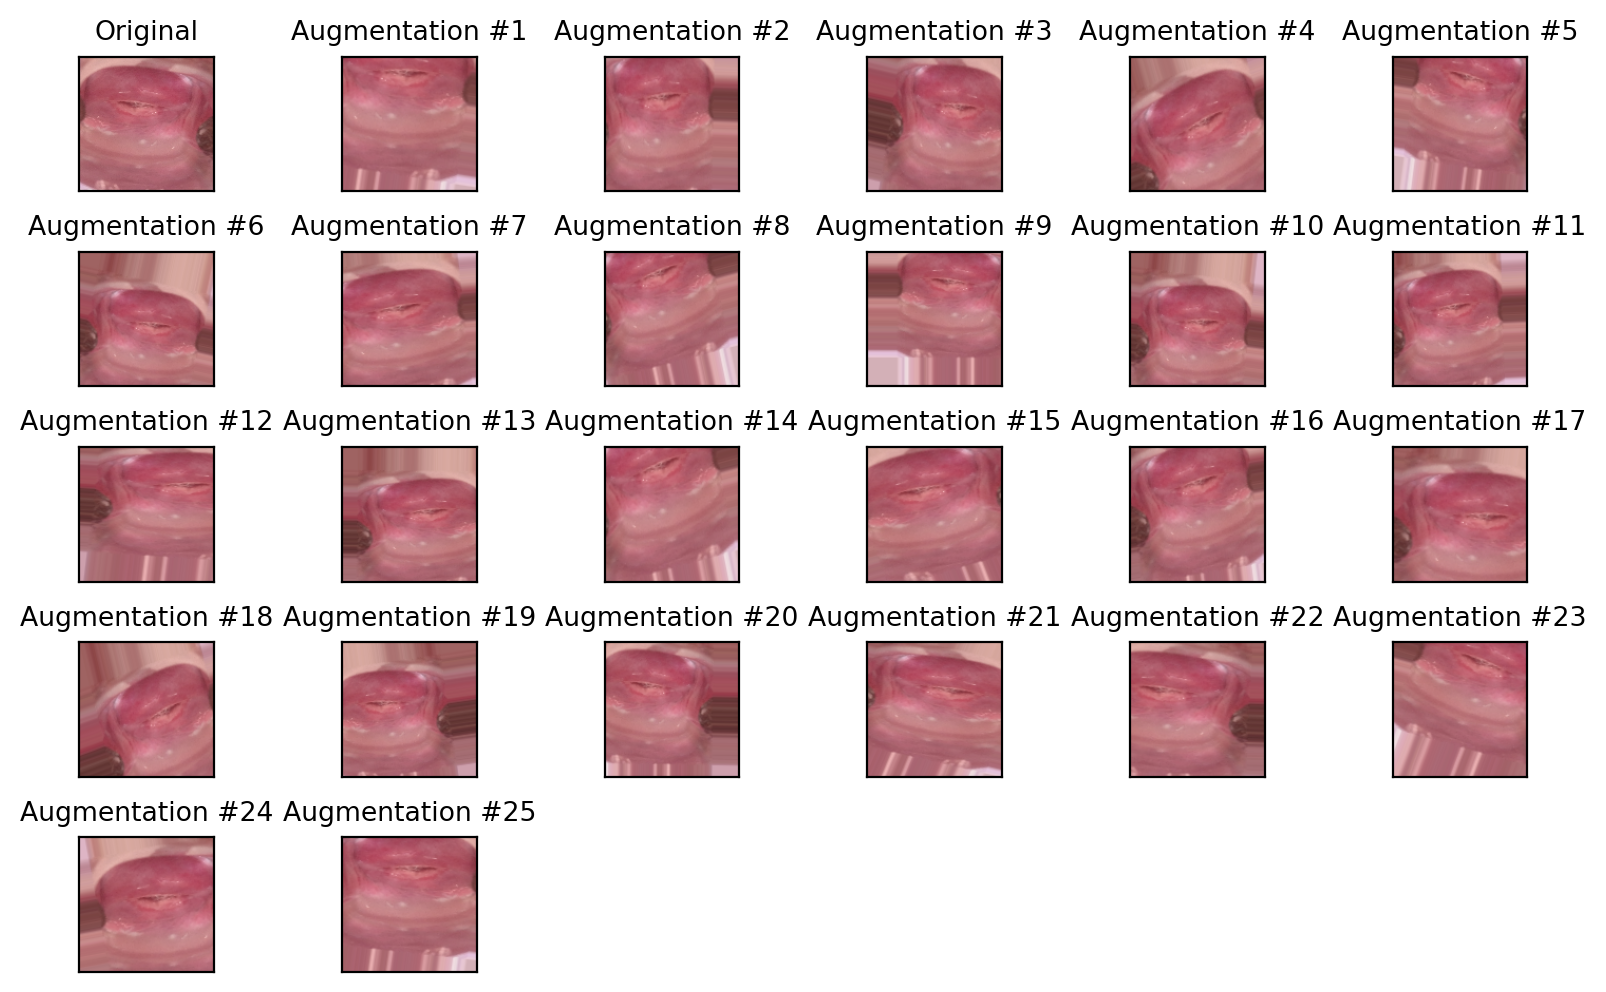

In [12]:
# Select a random image to plot

idx = np.random.randint(preprocessed_images.shape[0])

# Create a list of images to plot (original + augmented)

images = [preprocessed_images[idx]]
images.extend(augmented_images[i] for i in range(idx*n_augmentations, (idx+1)*n_augmentations))

# Create a list of titles for the subplots

titles = ['Original']
titles.extend([f"Augmentation #{i+1}" for i in range(n_augmentations)])

# Plot the images as subplots in a grid

num_images = len(images)
num_rows = int(np.sqrt(num_images))
num_cols = int(np.ceil(num_images / num_rows))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 5))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[i])
    else:
        ax.axis('off')
        
# Delete last subplot if empty
if num_images < num_rows * num_cols:
    fig.delaxes(axes.flat[-1])

plt.tight_layout()
plt.show()

In [13]:
# class_dict = {'group_1': 0, 'group_2': 1, 'group_3': 2}

# labels = np.array([class_dict[str(label)] for label in labels])

In [14]:
# Check if each label in the original dataset is equal to the label of its corresponding augmented images

for i in range(labels.shape[0]):
    label = labels[i]
    assert all(augmented_labels[i*n_augmentations:(i+1)*n_augmentations] == label)

# Combine the original and augmented images

all_images = np.concatenate((preprocessed_images, augmented_images), axis=0)

# Combine the original and augmented labels

all_labels = np.concatenate((labels, np.repeat(labels, n_augmentations)), axis=0)

# Check if the number of images and labels in the combined dataset is equal

assert all_images.shape[0] == all_labels.shape[0]

In [15]:
# Split data into training and testing sets, and convert labels to one-hot encoding

X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, 
                                                    test_size=0.1, random_state=42)

num_classes = len(np.unique(all_labels))

y_train = to_categorical(y_train, num_classes)

y_test = to_categorical(y_test, num_classes)

In [16]:
# Clear tf backend

tf.keras.backend.clear_session()

In [17]:
# Get the input shape and number of classes

input_shape = X_train.shape[1:]

In [18]:
# model = create_model(input_shape, num_classes, learning_rate)

model = new_model(X_train)

In [19]:
# Print the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 16)       64        
 hNormalization)                                                 
                                                        

In [ ]:
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

with tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        
        history = model.fit(X_train, y_train, batch_size=batch_size, 
                            epochs=1, verbose=0, 
                            validation_data=(X_test, y_test))

        train_acc = history.history['accuracy'][0]
        val_acc = history.history['val_accuracy'][0]
        train_loss = history.history['loss'][0]
        val_loss = history.history['val_loss'][0]

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        pbar.set_description(f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        pbar.update(1)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# Generate predictions for the test data

y_pred = model.predict(X_test)

# Convert predictions to labels

y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = np.argmax(y_test, axis=1)

In [ ]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi = 300)

# Plot training and validation accuracy over epochs
axs[0].plot(train_acc_list, linewidth=2)
axs[0].plot(val_acc_list, linewidth=2)
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['train', 'validation'], loc='best')

# Plot training and validation loss over epochs
axs[1].plot(train_loss_list, linewidth=2)
axs[1].plot(val_loss_list, linewidth=2)
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['train', 'validation'], loc='best')

# Show the plot
plt.show()

In [ ]:
# Define class dictionary
class_dict = {0: 'group_1', 1: 'group_2', 2: 'group_3'}

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, normalize='true')

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap = 'Blues', interpolation = 'None')

ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))

ax.set_xticklabels(class_dict.keys())
ax.set_yticklabels(class_dict.keys())

ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')

ax.set_title('Confusion Matrix')

for i in range(num_classes):
    for j in range(num_classes):
        text = ax.text(j, i, format(cm[i, j], '.2f'),
                       ha="center", va="center", color="white" if cm[i, j] > 0.5 else "black")

plt.colorbar(im)
plt.show()

In [ ]:
# Evaluate the model on the test data
score = model.evaluate(X_test, y_test, verbose=0)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert predictions from probabilities to labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calculate performance metrics
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Print performance metrics
print()
print(f'Test accuracy: {accuracy:.3f}')
print(f'Test precision: {precision:.3f}')
print(f'Test recall: {recall:.3f}')
print(f'Test F1-score: {f1:.3f}')
print()
print(f'Test confusion matrix:\n{cm}')
print()